# **Sponsorship Statistics Across YouTube Channels**
### *Powered by the SponsorBlock API, created by Ajay Ramachandran*

In [12]:
import pytube
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Local
import general
import plotting
import video_stats
import channel_stats

## Data Collection

In [36]:
import sponsorblock as sb

c = pytube.Channel("https://www.youtube.com/c/LinusTechTips")
video_urls = c.video_urls

data = general.get_rawdata(urls = video_urls[0:50], update = False)

# data = []
# client = sb.Client()
# for url in video_urls[0:100]:
#     try:
#         segments = [vars(x) for x in client.get_skip_segments(url)]
#         for key,val in enumerate(segments):
#             val["youtube_object"] = pytube.YouTube(url)
#             val["video_id"] = pytube.extract.video_id(url)
#             segments[key] = val
#         data = data + segments
#     except Exception as e:
#         # If 404 Not Found, this is because no one has submited
#         # segments for this particular video. It is still a valid
#         # data point, so we just fill it will 'empty' segment info.
#         if str(e) == "Not Found: 404 Not Found":
#             segments = [
#                 vars(sb.models.Segment(
#                     category = category,
#                     start = 0,
#                     end = 0,
#                     duration = 0
#                 )) for category in sb.utils.ALL_CATEGORIES
#             ]
#             for key,val in enumerate(segments):
#                 val["youtube_object"] = pytube.YouTube(url)
#                 val["video_id"] = pytube.extract.video_id(url)
#                 segments[key] = val
#             data = data + segments
#         else:
#             print(e)

## Data Cleaning

### Reorganize based on video

```
Format: [video_id, title, length, description, keywords, 
    publish_date, views, segment_selfpromo, segment_sponsor, ...]
segment_xyz = [ #List to hold all of a single type of segment present in a video
    {
        "start": 1.523,
        "end": 2.311,
        "duration": 0.788
    },
    {
        ...
    }, ...
]
```

In [37]:
data_df = pd.DataFrame(data)
data_df = data_df.drop(columns=["data","uuid","action_type"])
data_df = data_df[["video_id"] + list(data_df.columns.values)[:-1]]

pytube_attributes = ["title","length","description","keywords","publish_date","views"]
segment_categories = sb.utils.ALL_CATEGORIES
temp_data = []

for video_id in data_df["video_id"].unique().tolist():
    
    entry = [video_id]
    sub_df = data_df.loc[data_df["video_id"] == video_id]

    # It takes time for pytube to query all the video metadata,
    # so this pytube_attribute loop takes a while to run.
    for attribute in pytube_attributes:
        entry.append(getattr(sub_df.iloc[0]["youtube_object"], attribute))
    
    for category in segment_categories:

        category_df = sub_df.loc[data_df["category"] == category]
        temp_segment_category = []

        for key,val in enumerate([category_df.iloc[i] for i in range(len(category_df))]):
            
            temp_dict = {
                "start": val["start"],
                "end": val["end"],
                "duration": round(val["end"]-val["start"],3)
            }
            temp_segment_category.append(temp_dict)
        
        # Fill with 'empty' segments, avoid holes in dataset
        if category_df.empty:
            temp_segment_category = [
                {
                    "start": 0.0,
                    "end": 0.0,
                    "duration": 0.0
                }
            ]

        entry.append(temp_segment_category)

    temp_data.append(entry)

data_df = pd.DataFrame(temp_data,columns = ["video_id"] + pytube_attributes + segment_categories)



In [38]:
display(data_df)

,video_id,title,length,description,keywords,publish_date,views,sponsor,selfpromo,interaction,intro,outro,preview,music_offtopic,poi_highlight,filler
0,4V_pYA7Uq0U,I LOVE Paywalls. Thanks Intel!,767,Check out Jackery’s Solar Generator 1000 Pro a...,"[ECC, Memory, Error Correction Code, Intel, 12...",2022-09-25,258336,"[{'start': 71.283, 'end': 85.136, 'duration': ...","[{'start': 237.766, 'end': 253.465, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 759.347, 'end': 767.201, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 396.114, 'end': 398.615, 'duration'..."
1,8dEIy1YXJ4A,My wife vetoed my plan,1580,Thanks to Govee for sponsoring today's video! ...,[],2022-09-24,1312374,"[{'start': 33.875, 'end': 36.201, 'duration': ...","[{'start': 115.275, 'end': 122.901, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 51.726, 'end': 61.036, 'duration': ...","[{'start': 1562.578, 'end': 1579.481, 'duratio...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 317.316, 'end': 328.684, 'duration'..."
2,7YuiFlhe8j4,NVIDIA Thinks You're RICH - WAN Show September...,9503,Discover more about Shadow's Business Solution...,"[pcmr, building, competition, gamers, how to, ...",2022-09-23,602823,"[{'start': 132.198, 'end': 140.638, 'duration'...","[{'start': 149.722, 'end': 153.852, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 112.564, 'end': 132.298, 'duration'...","[{'start': 9483.665, 'end': 9502.655, 'duratio...","[{'start': 7.547, 'end': 112.931, 'duration': ...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 140.637, 'end': 140.637, 'duration'...","[{'start': 0.0, 'end': 3.695, 'duration': 3.69..."
3,3CDOSj8fZA4,Everyone said this was impossible,1754,"Try FreshBooks free, for 30 days, no credit ca...","[100 gigabit, datacenter networking, networkin...",2022-09-22,1576799,"[{'start': 66.837, 'end': 85.21, 'duration': 1...","[{'start': 19.77, 'end': 21.547, 'duration': 1...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 85.06, 'end': 94.148, 'duration': 9...","[{'start': 1739.676, 'end': 1753.981, 'duratio...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 7.794, 'duration': 7.79..."
4,cQbp64JRkdA,This 2300ft cable saved us THOUSANDS of dollar...,59,"The new new lab isn't that far, so why not use...","[ethernet, internet, gigabit, download, upload]",2022-09-21,620243,"[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]"
5,tHNQOJ_nsLc,The MOST Tricked Out Laptop,811,Thanks to MSI for sponsoring this video! You c...,"[laptop, lmsi, titan, desktop replacement, chu...",2022-09-21,1241754,"[{'start': 37.109, 'end': 46.761, 'duration': ...","[{'start': 137.241, 'end': 139.672, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 46.149, 'end': 55.496, 'duration': ...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 28.643, 'duration': 28...."
6,3RIp7CwkBeA,I Hope You Have a LOT of Money... RTX 4000 Ann...,568,"Try FreshBooks free, for 30 days, no credit ca...","[Nvidia, 4000, 4090, 4080, Ada, Love

### **Brief Visualization Detour**
- ### Total Segment Duration (in seconds) versus Publish Date

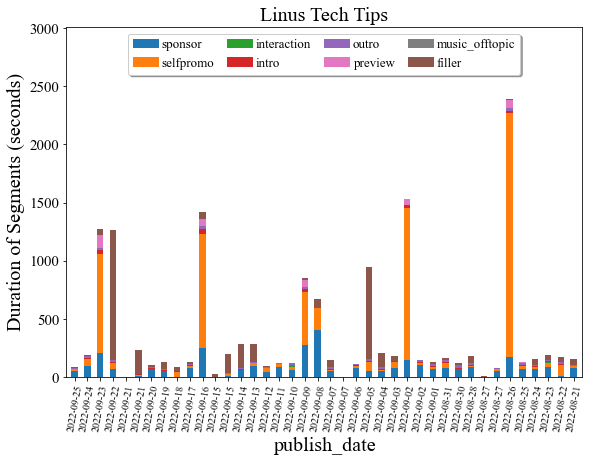

In [39]:
%matplotlib inline

importlib.reload(plotting)
plotting.make_channel_plot(data_df, x_axis="publish_date", plot_type="StackedSegBar",
    exclude=["poi_highlight"], method="segment_dur", title="Linus Tech Tips")

- ### Interactive version

    - Click on any of the bars to open up the YouTube video they correspond to

Try clicking directly on the features within the plot


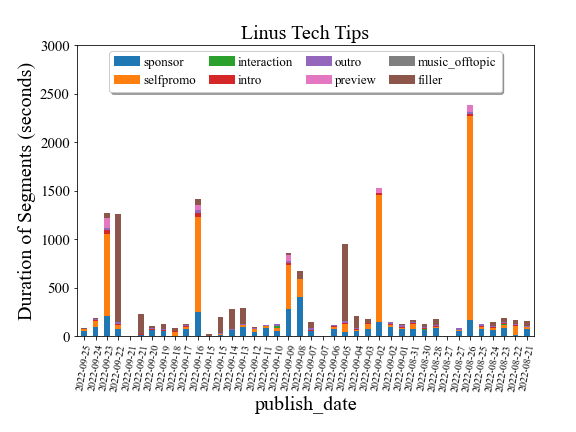

In [40]:
%matplotlib widget

# There is some bug between matplotlib and
# Jupyter notebooks and I haven't had time 
# to figure out which one is at fault.

# If this doesn't display correctly try 
# running all the cells in the notebook
# or running this one a few times. 

importlib.reload(plotting)
print("Try clicking directly on the features within the plot")
plotting.make_channel_plot(data_df, x_axis="publish_date", plot_type="StackedSegBar",
    exclude=["poi_highlight"], method="segment_dur", title="Linus Tech Tips",tight_layout_padding=4)

## Data Processing

- Process each video entry to further quantify their properties
- Tabulate stuff like title length, total segment duration, ect

In [41]:
importlib.reload(video_stats)
categories = general.get_categories(exclude=["poi_highlight"])
processed_data_df = data_df.apply(video_stats.calculate_all_stats, axis=1, args=([categories]))

In [42]:
display(processed_data_df)

,video_id,title,length,description,keywords,publish_date,views,sponsor,selfpromo,interaction,...,music_offtopic_total_dur,filler_total_dur,sponsor_total_num,selfpromo_total_num,interaction_total_num,intro_total_num,outro_total_num,preview_total_num,music_offtopic_total_num,filler_total_num
0,4V_pYA7Uq0U,I LOVE Paywalls. Thanks Intel!,767,Check out Jackery’s Solar Generator 1000 Pro a...,"[ECC, Memory, Error Correction Code, Intel, 12...",2022-09-25,258336,"[{'start': 71.283, 'end': 85.136, 'duration': ...","[{'start': 237.766, 'end': 253.465, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,2.501,2,2,0,0,1,0,0,1
1,8dEIy1YXJ4A,My wife vetoed my plan,1580,Thanks to Govee for sponsoring today's video! ...,[],2022-09-24,1312374,"[{'start': 33.875, 'end': 36.201, 'duration': ...","[{'start': 115.275, 'end': 122.901, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,11.368,7,6,0,1,1,0,0,1
2,7YuiFlhe8j4,NVIDIA Thinks You're RICH - WAN Show September...,9503,Discover more about Shadow's Business Solution...,"[pcmr, building, competition, gamers, how to, ...",2022-09-23,602823,"[{'start': 132.198, 'end': 140.638, 'duration'...","[{'start': 149.722, 'end': 153.852, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,54.164,3,17,0,2,1,1,0,2
3,3CDOSj8fZA4,Everyone said this was impossible,1754,"Try FreshBooks free, for 30 days, no credit ca...","[100 gigabit, datacenter networking, networkin...",2022-09-22,1576799,"[{'start': 66.837, 'end': 85.21, 'duration': 1...","[{'start': 19.77, 'end': 21.547, 'duration': 1...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,1120.801,3,5,0,1,1,0,0,20
4,cQbp64JRkdA,This 2300ft cable saved us THOUSANDS of dollar...,59,"The new new lab isn't that far, so why not use...","[ethernet, internet, gigabit, download, upload]",2022-09-21,620243,"[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,0.000,0,0,0,0,0,0,0,0
5,tHNQOJ_nsLc,The MOST Tricked Out Laptop,811,Thanks to MSI for sponsoring this video! You c...,"[laptop, lmsi, titan, desktop replacement, chu...",2022-09-21,1241754,"[{'start': 37.109, 'end': 46.761, 'duration': ...","[{'start': 137.241, 'end': 139.672, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,208.202,2,1,0,1,0,0,0,18
6,3RIp7CwkBeA,I Hope You Have a LOT of Money... RTX 4000 Ann...,568,"Try FreshBooks free, for 30 days, no credit ca...","[Nvidia, 4000, 4090, 4080, Ada, Lovelace, RTX,...",2022-09-20,1669722,"[{'start': 28.97, 'end': 47.438, 'duration': 1...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,13.504,2,0,0,1,1,0,0,2
7,0Ueel1wXnZk,First Water Cooled Mac Studio,1044,Thanks to MANSCAPED for sponsoring the video! ...,[],2022-09-19,1312566,"[{'start': 35.946, 'end': 52.27, 'duration': 1...","[{'start': 330.013, 'end': 331.417, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,58.391,2,1,0,1,1,0,0,8
8,bxya-divayE,I Made a Mistake...,1404,Thanks to ASUS for sponsoring today's video! C...,"[ASUS, ROG, ASUS ROG, ROG Swift, Monitor, Chun...",2022-09-18,1416352,"[{'start': 1371.167, 'end': 1373.266, 'duratio...","[{'start': 267.052, 'end': 279.668, 'duration'...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,31.395,2,3,0,1,0,0,0,3
9,Oijav9jJjqM,This almost BROKE me.,1184,Visit https://www.squarespace.com/LTT and use ...,"[tech, right to repair, camera repair, linus f...",2022-09-17,1585468,"[{'start': 37.813, 'end': 58.226, 'duration': ...","[{'start': 194.43, 'end': 211.341, 'duration':...","[{'start': 0.0, 'end': 0.0, 'duration': 0.0}]",...,0.0,14.382,2,1,0,1,1,0,0,2


# Analysis and Exploration of Data

### Content Percentage

- Compared to the earlier plots this gives normalized representation, making it easier to compare video to video
- See how including different categories changes the overall percentage of what is considered 'actual content'
    - Calculated in terms of total segment time across all checked (❎) categories divided by total video time

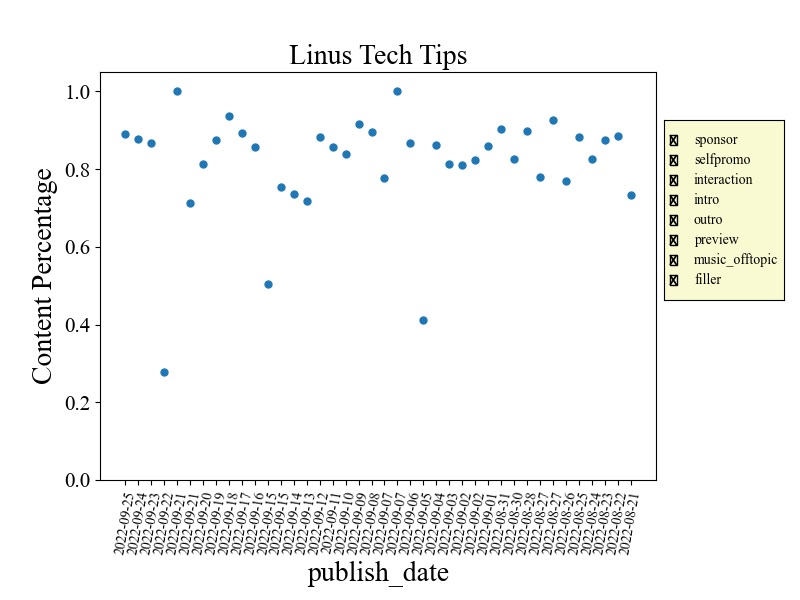

In [43]:
importlib.reload(plotting)
%matplotlib widget

# If plot is too large or small, try changing the figure dots per inch (dpi)
plt.rcParams['figure.dpi'] = 100

plotting.make_channel_plot(processed_data_df, x_axis="publish_date", plot_type="ScatterContentPercentage",
    exclude=["poi_highlight"], method="segment_dur", title="Linus Tech Tips", video_num_max=40)